<a href="https://colab.research.google.com/github/AgainstEntropy/ECE-GY-6143-ML/blob/main/8_svm_with_kernel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Support vector machines in depth

*Fraida Fund*

In this notebook, we will develop the intuition behind support vector machines and their use in classification problems.

#### Attribution

Parts of this notebook are modified versions of [In Depth: Support Vector Machines](https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html). <!--BOOK_INFORMATION--> <img align="left" style="padding-right:10px;" src="https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/figures/PDSH-cover-small.png?raw=1">

from [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content of that book is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).

The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).

In [21]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import ipywidgets as widgets
from ipywidgets import interact, fixed
from mpl_toolkits import mplot3d

# use seaborn plotting defaults
import seaborn as sns; sns.set_style('white')
from sklearn.datasets import make_blobs, make_circles
from sklearn.svm import SVC # "Support vector classifier"

## Generate linearly separable data

Consider the simple case of a binary classification task, in which the two classes of points are well separated:

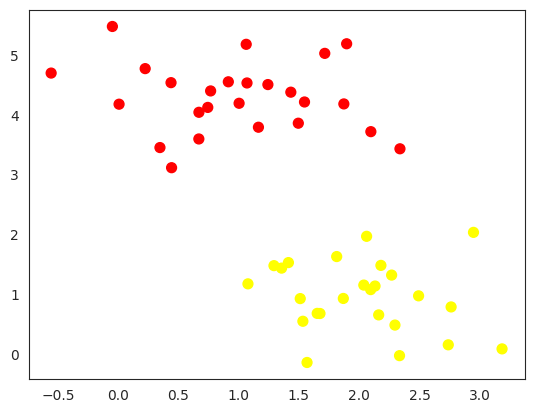

In [22]:
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear classifier would attempt to draw a straight line separating the two sets of data, and thereby create a model for classification. For two dimensional data like that shown here, this is a task we could do by hand.

But immediately we see a problem: there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw some of them as follows:

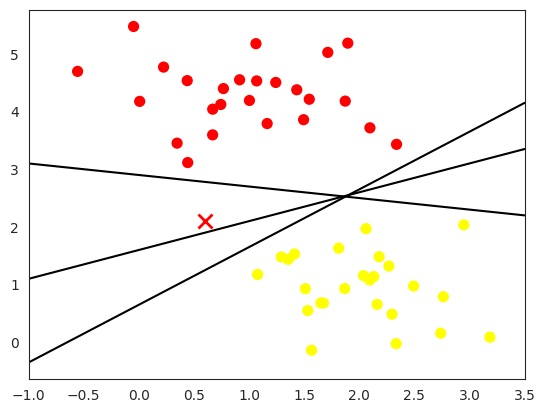

In [23]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

These are three *very* different separators which, nevertheless, perfectly discriminate between these samples. Depending on which you choose, a new data point (e.g., the one marked by the “X” in this plot) will be assigned a different label! Evidently our simple intuition of “drawing a line between classes” is not enough, and we need to think a bit deeper.

## Maximal margin classifier

Support vector machines offer one way to improve on this. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a *margin* of some width, up to the nearest point. Here is an example of how this might look:

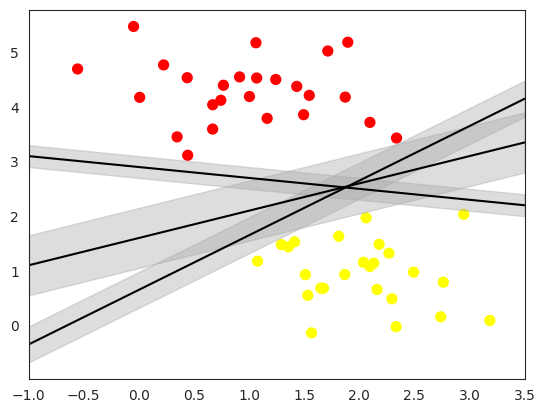

In [24]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

Notice here that if we want to maximize this width, the middle fit is clearly the best.

This is the intuition of *support vector machines*. In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. Support vector machines are an example of such a *maximal margin* estimator.

## Fitting a support vector machine

Let’s see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the `C` parameter to a very large number (we’ll discuss the meaning of these in more depth momentarily).

In [25]:
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what’s happening here, let’s create a quick convenience function that will plot SVM decision boundaries for us:

In [26]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1,
                   facecolors='none', edgecolors= 'black');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

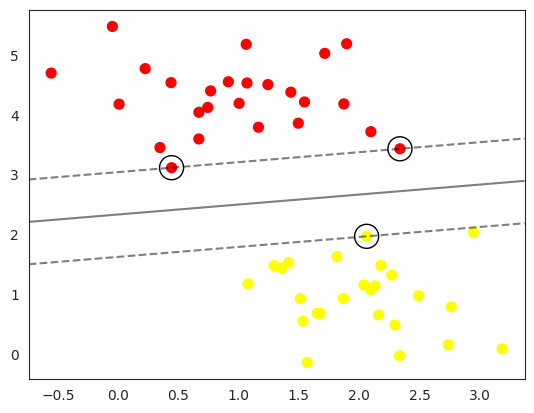

In [27]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points lie on the margin: they are indicated by the black circles in this figure. These points are the pivotal elements of this fit, and are known as the *support vectors*, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the `support_vectors_` attribute of the classifier:

In [28]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

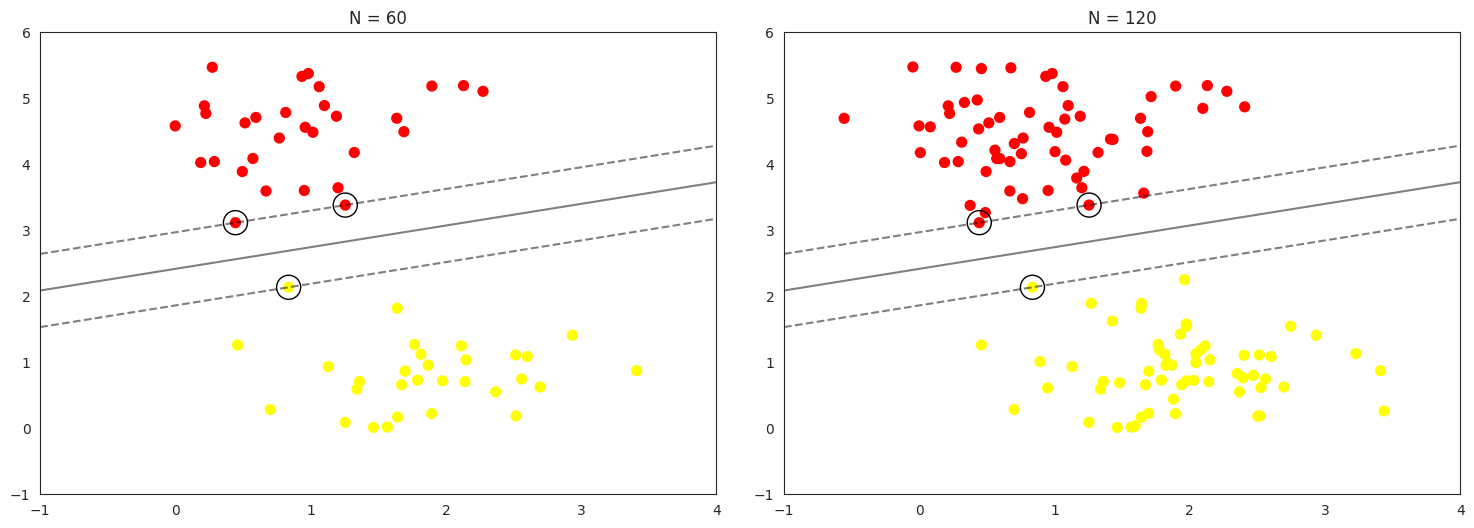

In [31]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

However, the model is *not* insensitive to the addition of points that violate the margin.

You can change the value of $N$ and view this feature of the SVM model interactively:

In [13]:
interact(plot_svm, N=widgets.IntSlider(min=10, max=200, step=1, value=10), ax=fixed(None));

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

## Softening margins

Our discussion thus far has centered around very clean datasets, in which a perfect decision boundary exists. But what if your data has some amount of overlap? For example, you may have data like this:

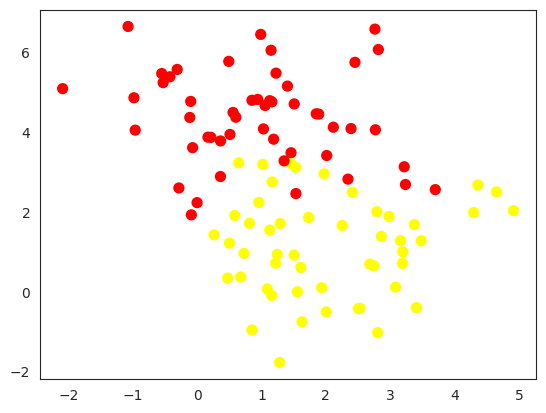

In [32]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which “softens” the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$.

We can better understand the effect of $C$ by referring back to the SVM optimization problem:

$$
\begin{aligned}
\operatorname*{minimize}_{\mathbf{w}, \mathbf{\epsilon}} \quad & \frac{1}{2} \sum_{j=1}^p w_j^2  + C \sum_{i=1}^n \epsilon_i  \\
\text{subject to} \quad & y_i(w_0 + \sum_{j=1}^p w_j x_{ij}) \geq 1-\epsilon_i, \quad \forall i \\
& \epsilon_i \geq 0, \quad \forall i
\end{aligned}
$$

The greater the value of $C$, the more heavily the “margin violators” penalize the overall objective function. Therefore,

-   If $C$ is large, the margin must be narrow (with few “margin violators”).
-   If $C$ is small, the margin may be wider (with more “margin violators”).

The plot shown below gives a visual picture of how a changing $C$ parameter affects the final fit, via the softening of the margin:

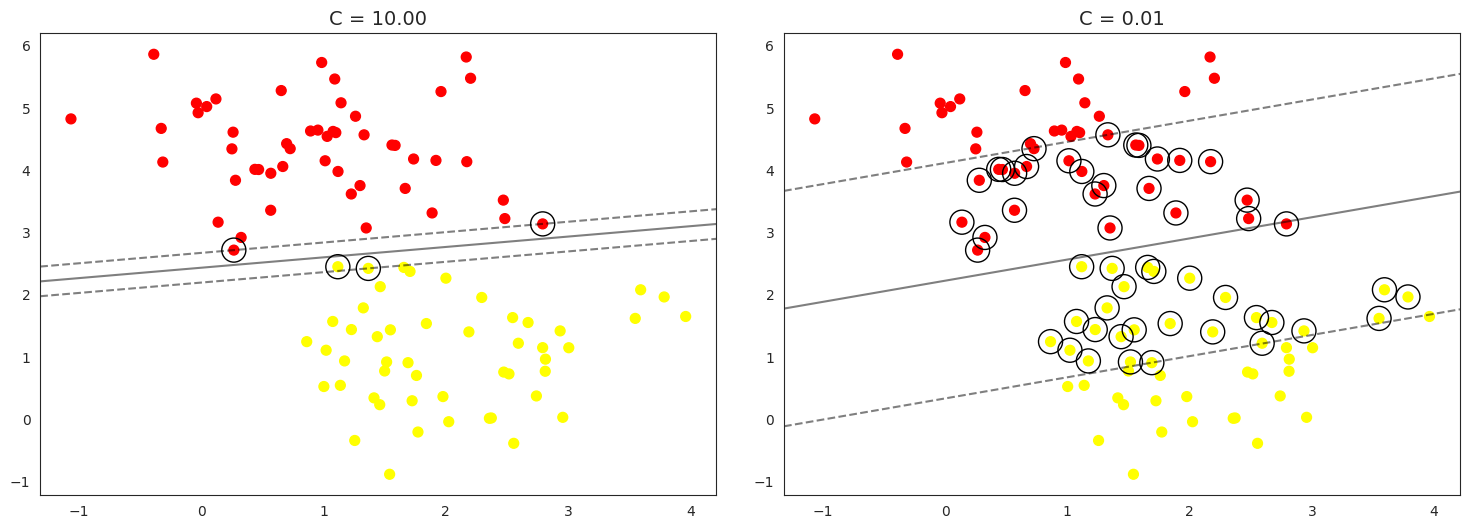

In [33]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.01]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.2f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.

## Bias and variance

In [34]:
n_repeat = 100
n_test = 500
n_train = 100
sigma= 0.8
cluster_centers = np.array([[-1,1],[2,2]])

In [35]:
y_predict = np.zeros((n_test, n_repeat, 2))

In [36]:
x_test, y_test = make_blobs(n_samples=n_test, centers=cluster_centers,
                  random_state=0, cluster_std=sigma)

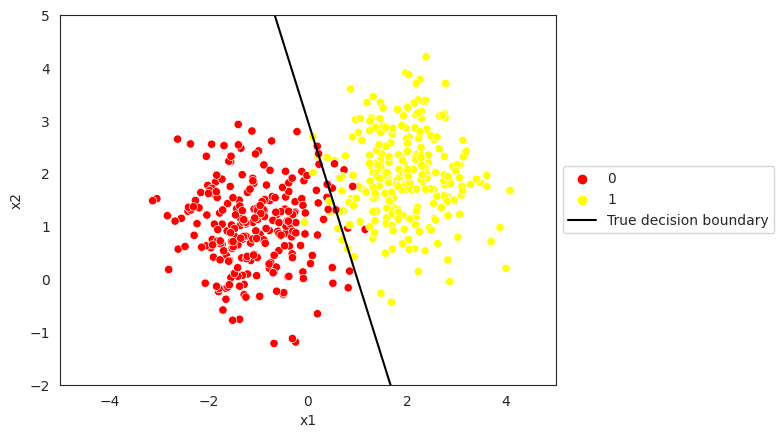

In [37]:
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, palette=['red','yellow']);

plt.xlabel("x1");
plt.ylabel("x2");
plt.xlim(-5,5);
plt.ylim(-2,5);

# get the true decision boundary
mid = [cluster_centers[:,0].mean(), cluster_centers[:,1].mean()]
slp = -1.0/((cluster_centers[1,1]-cluster_centers[0,1])/(cluster_centers[1,0]-cluster_centers[0,0]))
b = mid[1]-slp*mid[0]
x_true = np.arange(-5,5)
y_true = slp*x_true + b
sns.lineplot(x=x_true, y=y_true, color='black', label="True decision boundary")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

Suppose we want to train a model to classify two “blobs” of data.

Which will have greater bias, and which will have greater variance?

-   **Model A**: Linear SVM with $C=0.001$

-   **Model B**: Linear SVM with $C=100$

Remember: $C$ is the tuning parameter in the SVM problem

$$
\begin{aligned}
\operatorname*{minimize}_{\mathbf{w}, \mathbf{\epsilon}} \quad & \frac{1}{2} \sum_{j=1}^p w_j^2  + C \sum_{i=1}^n \epsilon_i  \\
\text{subject to} \quad & y_i(w_0 + \sum_{j=1}^p w_j x_{ij}) \geq 1-\epsilon_i, \quad \forall i \\
& \epsilon_i \geq 0, \quad \forall i
\end{aligned}
$$

The greater the value of $C$, the more heavily the “margin violators” penalize the overall objective function.

Simulation iteration: 100%|██████████| 100/100 [00:41<00:00,  2.42it/s]


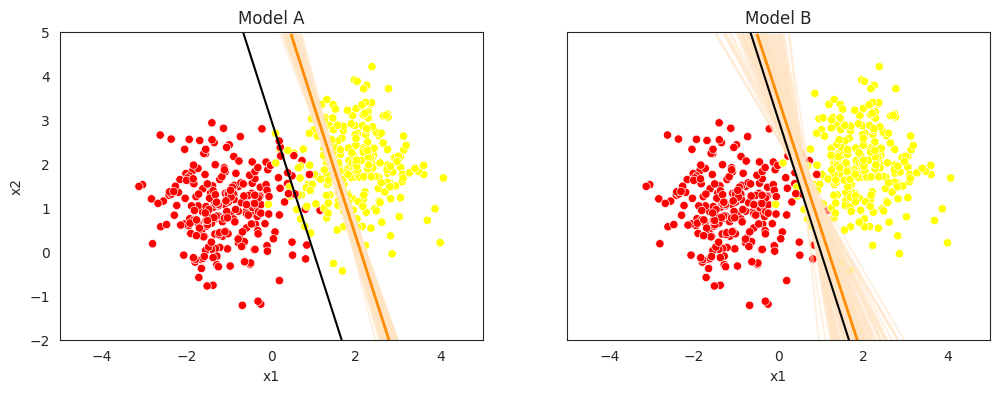

In [38]:
Z_sim = np.zeros((40000, n_repeat, 2))

fig = plt.figure(figsize=(12,4))
ax_a, ax_b = fig.subplots(1, 2, sharex=True, sharey=True)

# now simulate training the model many times, on different training data every time
# and evaluate using the test data
for i in tqdm(range(n_repeat), total=n_repeat, desc="Simulation iteration"):

  # train both models on newly generated training data
  X, y = make_blobs(n_samples=n_test, centers=cluster_centers,
                  cluster_std=sigma)

  clf_a = SVC(kernel='linear', C=0.001).fit(X, y)
  clf_b = SVC(kernel='linear', C=100.0).fit(X, y)

  y_predict[:, i, 0] = clf_a.predict(x_test)
  y_predict[:, i, 1] = clf_b.predict(x_test)


  xx, yy = np.meshgrid(np.arange(-5, 5, .05),
                      np.arange(-5, 5, .05))

  Z = clf_a.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 0] = Z
  Z = Z.reshape(xx.shape)
  ax_a.contour(xx, yy, Z, levels=[0.5], alpha=0.5, colors='bisque');

  plt.xlim(-5,5);
  plt.ylim(-2,5);

  Z = clf_b.decision_function(np.c_[xx.ravel(), yy.ravel()])
  Z_sim[:, i, 1] = Z
  Z = Z.reshape(xx.shape)
  ax_b.contour(xx, yy, Z, levels=[0.5], alpha=0.5, colors='bisque');

  plt.xlim(-5,5);
  plt.ylim(-2,5);


cs_a = ax_a.contour(xx, yy, Z_sim[:,:,0].mean(axis=1).reshape(200,200), levels=[0.5], colors='darkorange', linewidths=2);
cs_b = ax_b.contour(xx, yy, Z_sim[:,:,1].mean(axis=1).reshape(200,200), levels=[0.5], colors='darkorange', linewidths=2);

# plot data
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_a, legend=False, palette=['red','yellow']);
sns.scatterplot(x=x_test[:,0], y=x_test[:,1], hue=y_test, ax=ax_b, legend=False, palette=['red','yellow']);

sns.lineplot(x=x_true, y=y_true, color='black', ax=ax_a)
sns.lineplot(x=x_true, y=y_true, color='black', ax=ax_b)


ax_a.set_title("Model A");
ax_b.set_title("Model B");

ax_a.set_ylabel("x2");
ax_a.set_xlabel("x1");
ax_b.set_xlabel("x1");

## Beyond linear boundaries: Kernel SVM

Where SVM becomes extremely powerful is when it is combined with *kernels*.

In linear regression, we projected our data into higher-dimensional space defined by polynomials or other basis functions, and thereby were able to fit for nonlinear relationships with a linear classifier.

In SVM models, we can use a version of the same idea. To motivate the need for kernels, let’s look at some data that is not linearly separable:

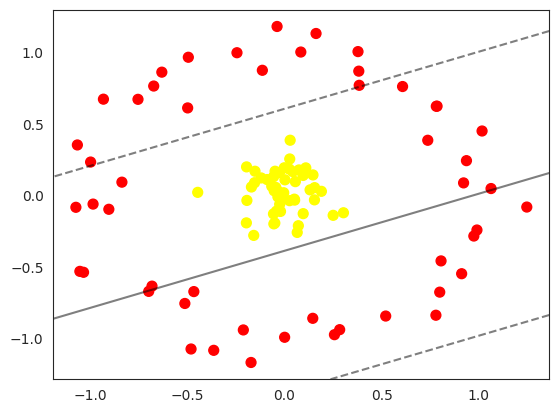

In [39]:
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will *ever* be able to separate this data. But we can draw a lesson from the basis function regressions, and think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.

For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle clump.

Definition: The RBF kernel is defined as

$$K(x,z) = \exp(-\frac{\|x-z\|^2_2}{\sigma^2})$$

where $\sigma$ is the bandwidth, or equivalently, using a $\gamma$ parameter,

$$K(x, z) = \exp(-\gamma \| x - z \|^2_2 )$$

When we say we compute the RBF kernel centered on the middle clump, we mean that we hold $z$ fixed at the origin, which is the center of the middle clump, and compute the kernel for every $x$.

In [40]:
r = np.exp(-((X) ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot:

In [41]:
def plot_3D(elev=30, azim=30, X=X, y=y):
    plt.figure(figsize=(7,7))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

    plt.show()

interact(plot_3D,
         elev=widgets.IntSlider(min=-90, max=90, step=10, value=30),
         azim=widgets.IntSlider(min=-90, max=90, step=10, value=30),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90, step=10), IntSlider(value=30, d…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, *r*=0.7.

Here we had to choose and carefully tune our projection: if we had not centered our radial basis function in the right location, we would not have seen such clean, linearly separable results. In general, the need to make such a choice is a problem: we would like to somehow automatically find the best basis functions to use.

One strategy to this end is to compute a basis function centered at *every* point in the dataset, and let the SVM algorithm sift through the results. This type of basis function transformation is known as a *kernel transformation*, as it is based on a similarity relationship (or kernel) between each pair of points.

A potential problem with this strategy—projecting $N$ points into $N$ dimensions—is that it might become very computationally intensive as $N$ grows large. However, because of the *kernel trick*, a fit on kernel-transformed data can be done implicitly—that is, without ever building the full $N$-dimensional representation of the kernel projection! This kernel trick is built into the SVM, and is one of the reasons the method is so powerful.

In `sklearn`, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the `kernel` model hyperparameter:

In [42]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

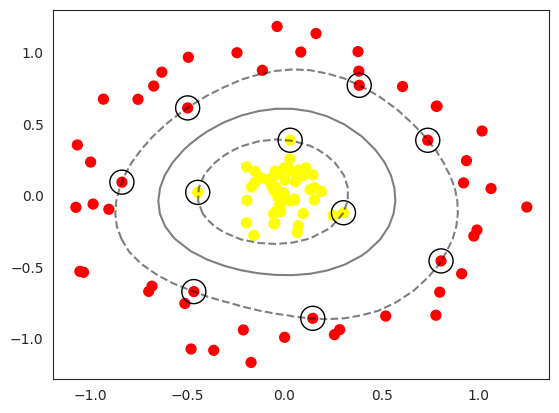

In [43]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary.

### 3D visualization of support vectors for RBF kernel

In [44]:
from sklearn.metrics.pairwise import rbf_kernel


colors = ['red','yellow']
C = 1
gamma = 10

clf = SVC(kernel='rbf', C=C, gamma=gamma)
clf.fit(X, y)

def plot_3D(elev=30, azim=30, sv=[], use_alpha=False, X=X, y=y, gamma=gamma):

    plt.figure(figsize=(12,12))
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], 0, c=y, s=50, cmap='autumn', alpha=0.4, edgecolor='black')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')
    ax.set_zlim(-1, 1)


    # Make data.
    xx1 = np.linspace(-1.5, 1.5, 30)
    xx2 = np.linspace(-1.5, 1.5, 30)

    X1, X2 = np.meshgrid(xx1, xx2)
    coords = np.column_stack((X1.ravel(), X2.ravel()))
    Z = np.zeros((X1.shape[0], X1.shape[1]))
    for sidx in sv:
      s = clf.support_vectors_[sidx]
      a = clf.dual_coef_[0][sidx]
      if not use_alpha:
        a =  np.sign(a)
      z = rbf_kernel(coords, [s], gamma=gamma)
      Z = Z + a*z.reshape((X1.shape[0], X1.shape[1]))
      ax.scatter3D(clf.support_vectors_[sidx][0], clf.support_vectors_[sidx][1], 0,
                  edgecolor='black', color=colors[int(np.clip(np.sign(clf.dual_coef_[0][sidx]), 0, 1))], s=100)

    surf = ax.plot_surface(X1, X2, Z, cmap='autumn', alpha=0.1, vmin=-1, vmax=1,
                      linewidth=0, antialiased=False)

    plt.show()

interact(plot_3D,
         elev=widgets.IntSlider(min=-90, max=90, step=10, value=30),
         azim=widgets.IntSlider(min=-90, max=90, step=10, value=30),
         sv=widgets.SelectMultiple(options=list(np.arange(np.sum(clf.n_support_))), value=[]),
         use_alpha = widgets.Checkbox(value=False),
         gamma=fixed(gamma), X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90, step=10), IntSlider(value=30, d…